In [13]:
import pyspark as pysp
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy as np

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import DecisionTreeClassifier,NaiveBayes,LogisticRegression

from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import NGram,OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
# sc = pysp.context.SparkContext()
spark = pysp.sql.SparkSession.builder \
    .appName("text_classification_trainer") \
    .master("local") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/15 10:49:39 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/15 10:49:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/15 10:49:39 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/05/15 10:49:39 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [4]:
df = spark.read.csv('gs://bdl2022/YELP_train.csv/', inferSchema = True)

In [4]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)



In [8]:
df.count()

11558702

In [4]:
df.select('_c0', '_c1', '_c2').show(5)

+--------------------+----+-------------------+
|                 _c0| _c1|                _c2|
+--------------------+----+-------------------+
|--30_8IhuyMHbSOcN...|   0|2018-04-30 16:56:24|
|--7PUidqRWpRSpXeb...|   0|2019-11-02 23:30:02|
|The exterior and ...|null|               null|
|Drug use action j...|null|               null|
|Pan scrambler was...|null|               null|
+--------------------+----+-------------------+
only showing top 5 rows



In [6]:
df.select('_c3', '_c4', '_c5').show(5)

+----+--------------------+----+
| _c3|                 _c4| _c5|
+----+--------------------+----+
|   0|DBJXMz1RIr91eFUd0...| 4.0|
|   0|0O4RqD91ZHdCPw4rU...| 1.0|
|null|                null|null|
|null|                null|null|
|null|                null|null|
+----+--------------------+----+
only showing top 5 rows



In [7]:
df.select('_c6', '_c7', '_c8').show(5)

+--------------------+----+--------------------+
|                 _c6| _c7|                 _c8|
+--------------------+----+--------------------+
|My child has been...|   1|LH2QmlXtq8CLji65l...|
|Lunchtime while v...|null|                null|
|                null|null|                null|
|                null|null|                null|
|                null|null|                null|
+--------------------+----+--------------------+
only showing top 5 rows



In [9]:
'''0, 4, 8 = ids
   2 = date
   6 = review
   5 = targets
   1, 3, 7 = votes'''

'0, 4, 8 = ids\n   2 = date\n   6 = review\n   5 = targets\n   1, 3, 7 = votes'

In [5]:
df.createOrReplaceTempView("data")

In [6]:
data = spark.sql("SELECT _c1, _c3, _c6, _c7, _c5 FROM data")

In [7]:
data.show(5)

+----+----+--------------------+----+----+
| _c1| _c3|                 _c6| _c7| _c5|
+----+----+--------------------+----+----+
|   0|   0|My child has been...|   1| 4.0|
|   0|   0|Lunchtime while v...|null| 1.0|
|null|null|                null|null|null|
|null|null|                null|null|null|
|null|null|                null|null|null|
+----+----+--------------------+----+----+
only showing top 5 rows



In [8]:
data = data.withColumn("_c1", data["_c1"].cast(IntegerType()))
data = data.withColumn("_c3", data["_c3"].cast(IntegerType()))
data = data.withColumn("_c7", data["_c7"].cast(IntegerType()))
data = data.withColumn("_c5", data["_c5"].cast(IntegerType()))

In [9]:
data = data.dropna()  #filter("_c1 is not NULL and _c3 is not NULL and _c6 is not NULL and _c7 is not NULL and _c5 is not NULL")

In [11]:
data.count()

3659598

In [10]:
data = data.filter('_c1 >= 0 and _c3 >= 0 and _c7 >= 0 and _c5 <= 5 and _c5 > 0')

In [53]:
gre_histogram_c1 = data.select('_c1').rdd.flatMap(lambda x: x).histogram(11)
gre_histogram_c3 = data.select('_c3').rdd.flatMap(lambda x: x).histogram(11)
gre_histogram_c7 = data.select('_c7').rdd.flatMap(lambda x: x).histogram(11)
gre_histogram_c5 = data.select('_c5').rdd.flatMap(lambda x: x).histogram(11)

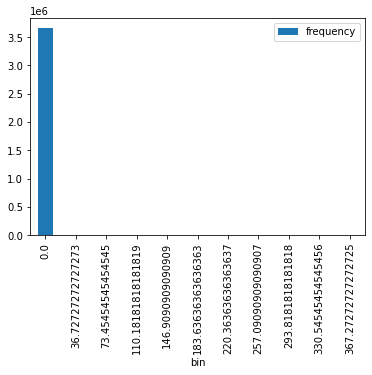

In [54]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram_c1)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

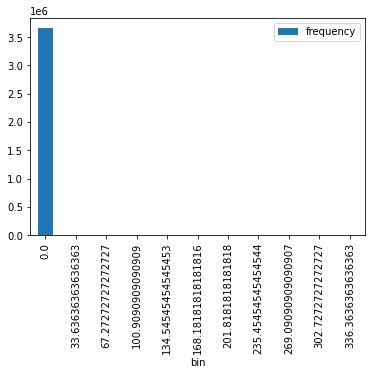

In [55]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram_c3)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

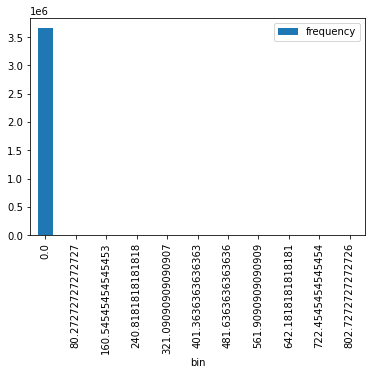

In [56]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram_c7)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

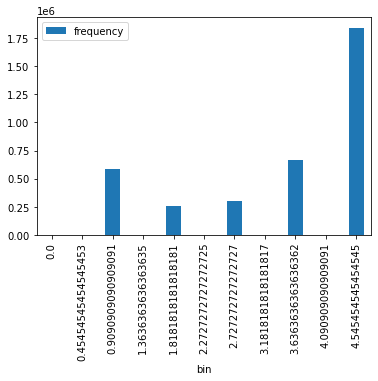

In [62]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram_c5)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

## Model building

In [11]:
data.show(5)

+---+---+--------------------+---+---+
|_c1|_c3|                 _c6|_c7|_c5|
+---+---+--------------------+---+---+
|  0|  0|My child has been...|  1|  4|
|  0|  0|Eh.. not that gre...|  6|  2|
|  0|  0|4706 Paris Ave, N...|  0|  1|
|  0|  0|We recently had o...|  0|  5|
|  0|  0|Very poor experie...|  0|  1|
+---+---+--------------------+---+---+
only showing top 5 rows



In [23]:
def build_twograms(inputCol = ["_c6", "_c5"], n = 2):
    tokenizer = [Tokenizer(inputCol = inputCol[0], outputCol = "word")]
    stopwordsRemover = [StopWordsRemover(inputCol="word", outputCol="words")]
    ngrams = [
    
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]
 
    cv = [
        CountVectorizer(vocabSize=1024,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]
 
    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
     
    lr = [LogisticRegression(labelCol=inputCol[-1], featuresCol="features",maxIter=20, regParam=0.1)]  
    return Pipeline(stages=tokenizer + stopwordsRemover + ngrams + cv + idf+ assembler +lr)

In [24]:
data_train, data_test = data.randomSplit([0.8, 0.2], seed = 42)

In [ ]:
twogram_pipelineFit = build_twograms().fit(data_train)

In [ ]:
# twogram_pipelineFit.save('gs://ch18b013mkvr/modelpath/')

In [ ]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol = "_c5", predictionCol="prediction")
predictionAndTarget = twogram_pipelineFit.transform(data_test).select("_c5", "prediction")

In [ ]:
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
print("Accuracy of logistic is = %g"% (acc))
print("F1 of logistic is = %g"% (f1))